In [1]:
#!pip install scikit-plot

In [2]:
import pandas as pd
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
stop = stopwords.words('english')

In [4]:
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.max_rows', None)

In [5]:
pysqldf = lambda q: sqldf(q, globals())

In [6]:
# setting a couple of workbook variables
text_source = "transcript"
tag = "tobacco"

In [7]:
df_human = pd.read_csv("data/classifications.csv")
df_ml = pd.read_csv("data/transcript_accuracy.csv")

In [8]:
#df_ml.head()

In [9]:
#df_human.head(1)

In [10]:
df_dataset = pysqldf(f"""
SELECT dh.*, dml.{text_source}, dml.`avg(confidence)` as avg_confidence
FROM 
    df_human dh
JOIN
    df_ml dml
ON dh.ID = dml.id
    WHERE description is not NULL
    AND description != 'error code 224003'
    AND subject NOT LIKE '%href%'
""")

In [11]:
len(df_dataset)

322

In [12]:
#df_dataset.head(2)

In [13]:
#df_dataset.set_index("ID", inplace=True)

In [14]:
df = pysqldf(f"""
SELECT 
    ID,
    subject,  
    {text_source},
    avg_confidence,
    CASE
        WHEN subject LIKE '%{tag}%' THEN 1
        ELSE 0
    END AS category
FROM df_dataset
""")

In [15]:
df.set_index("ID", inplace=True)

In [16]:
len(df)

322

In [17]:
df_train, df_test = train_test_split(df, test_size=0.5)

In [18]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop)),
    ('clf', RandomForestClassifier())
    ])

In [19]:
X_train = text_clf['vect'].fit_transform(df_train[text_source])

In [20]:
pd.set_option('display.max_rows', None)
#df_vector.T

In [21]:
#df_train.iloc[0][text_source]

In [22]:
X_train = text_clf.fit(df_train[text_source], df_train['category'])

In [23]:
feature_df = pd.DataFrame({"feature": text_clf['vect'].get_feature_names_out(), 
                           'importance': text_clf['clf'].feature_importances_})

In [24]:
y_proba = text_clf.predict_proba(df_test[text_source])
y_true = df_test['category']

In [25]:
y_pred = [y_proba[i][1] for i in range(len(y_proba))]

In [26]:
#y_pred

In [27]:
import numpy as np
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
precision = list(precision)
recall = list(recall)
thresholds = list(thresholds) + [1]

In [28]:
thresholds

[0.18,
 0.24,
 0.25,
 0.56,
 0.62,
 0.64,
 0.67,
 0.68,
 0.75,
 0.76,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1]

In [29]:
precision

[0.9192546583850931,
 0.925,
 0.9308176100628931,
 0.9367088607594937,
 0.9426751592356688,
 0.9423076923076923,
 0.9483870967741935,
 0.9545454545454546,
 0.9607843137254902,
 0.9605263157894737,
 0.9602649006622517,
 0.96,
 0.959731543624161,
 0.9594594594594594,
 0.9657534246575342,
 0.9647887323943662,
 0.9645390070921985,
 0.9626865671641791,
 0.9612403100775194,
 0.96,
 0.9646017699115044,
 0.9636363636363636,
 0.9607843137254902,
 0.9666666666666667,
 0.9571428571428572,
 0.9795918367346939,
 0.9736842105263158,
 1.0,
 1.0,
 1.0,
 1.0]

In [30]:
recall

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9932432432432432,
 0.9932432432432432,
 0.9932432432432432,
 0.9932432432432432,
 0.9864864864864865,
 0.9797297297297297,
 0.972972972972973,
 0.9662162162162162,
 0.9594594594594594,
 0.9527027027027027,
 0.9256756756756757,
 0.918918918918919,
 0.8716216216216216,
 0.8378378378378378,
 0.8108108108108109,
 0.7364864864864865,
 0.7162162162162162,
 0.6621621621621622,
 0.5878378378378378,
 0.4527027027027027,
 0.32432432432432434,
 0.25,
 0.1891891891891892,
 0.0472972972972973,
 0.013513513513513514,
 0.0]

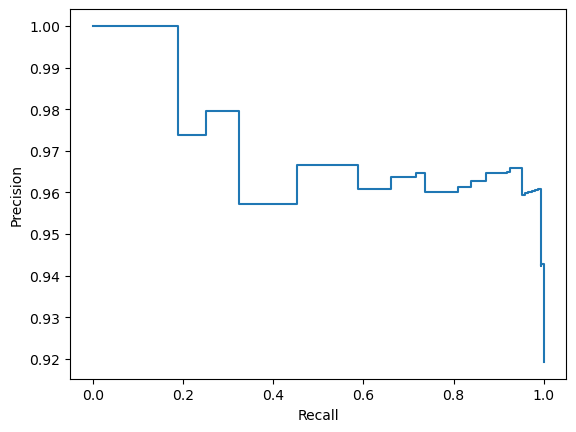

In [31]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

If we decrease the false negative (select more positives), recall always increases, but precision may increase or decrease. Generally, for models better than random, precision and recall have an inverse relationship (@pythinker's answer), but for models worse than random, they have a direct relationship (@kbrose's example).

https://datascience.stackexchange.com/questions/49117/inverse-relationship-between-precision-and-recall

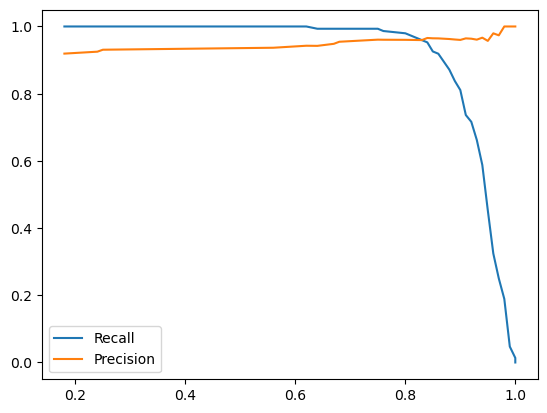

In [32]:
import matplotlib.pyplot as plt
import numpy as np

xticks = thresholds
plt.plot(thresholds, list(recall), label="Recall")
plt.plot(thresholds, list(precision), label="Precision")
leg = plt.legend()
plt.show()

In [33]:
df = pd.DataFrame({'threshold':thresholds, 'precision':precision, 'recall':recall})

In [34]:
df

,threshold,precision,recall
0,0.18,0.919255,1.000000
1,0.24,0.925000,1.000000
2,0.25,0.930818,1.000000
3,0.56,0.936709,1.000000
4,0.62,0.942675,1.000000
5,0.64,0.942308,0.993243
6,0.67,0.948387,0.993243
7,0.68,0.954545,0.993243
8,0.75,0.960784,0.993243
9,0.76,0.960526,0.986486
